#Bayesian Tree Optimization LGB

##Preprocessing inspired by [this notebook](https://www.kaggle.com/code/emaksone/eda-with-feature-engineering/notebook)

In [ ]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline 

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

import os
import gc
from itertools import product
from tqdm import tqdm_notebook
import time
import os

In [ ]:
DATA_FOLDER = '/content/kaggle_data/'
sales = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv'))
shops_df = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
cat_df = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
items_df = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
test_df = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))

In [ ]:
sales = sales[sales['item_cnt_day'] < 900]
sales = sales[(sales['item_price']<100000) & (sales['item_price']>0)]
scaler = MinMaxScaler().fit(sales[['item_price']])
sales['item_price'] = scaler.transform(sales[['item_price']])

In [ ]:
# Якутск Орджоникидзе, 56
sales.loc[sales['shop_id'] == 0, 'shop_id'] = 57
test_df.loc[test_df['shop_id'] == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
sales.loc[sales['shop_id'] == 1, 'shop_id'] = 58
test_df.loc[test_df['shop_id'] == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
sales.loc[sales['shop_id'] == 10, 'shop_id'] = 11
test_df.loc[test_df['shop_id'] == 10, 'shop_id'] = 11

In [ ]:
shops_df.loc[shops_df['shop_name'] == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops_df['city'] = shops_df['shop_name'].str.split(' ').map(lambda x: x[0])
shops_df.loc[shops_df['city'] == '!Якутск', 'city'] = 'Якутск'
shops_df['city_code'] = LabelEncoder().fit_transform(shops_df['city'])
shops_df.loc[shops_df['shop_id'].isin([9,12, 55]), 'city_code'] = 999
shops_df = shops_df[['shop_id','city_code']]

In [ ]:
cat_df.loc[cat_df['item_category_id'] == 8, 'item_category_name'] = 'Билеты'
cat_df.loc[cat_df['item_category_id'] == 26, 'item_category_name'] = 'Игры Android'
cat_df.loc[cat_df['item_category_id'] == 27, 'item_category_name'] = 'Игры MAC'
cat_df.loc[cat_df['item_category_id'] == 31, 'item_category_name'] = 'Игры PC'
cat_df.loc[cat_df['item_category_id'] == 34, 'item_category_name'] = 'Карты оплаты - Live!'
cat_df.loc[cat_df['item_category_id'] == 36, 'item_category_name'] = 'Карты оплаты - Windows'
cat_df.loc[cat_df['item_category_id'] == 44, 'item_category_name'] = 'Карты оплаты - Windows'
cat_df.loc[cat_df['item_category_id'] == 74, 'item_category_name'] = 'Программы - MAC'
#43 equals 44
cat_df.drop(cat_df[cat_df['item_category_id'] == 44].index, inplace=True)
#75 == 76
cat_df.drop(cat_df[cat_df['item_category_id'] == 76].index, inplace=True)
#77 == 78
cat_df.drop(cat_df[cat_df['item_category_id'] == 78].index, inplace=True)

items_df.loc[items_df['item_category_id'] == 44, 'item_category_id'] = 43
items_df.loc[items_df['item_category_id'] == 76, 'item_category_id'] = 75
items_df.loc[items_df['item_category_id'] == 78, 'item_category_id'] = 77

In [ ]:
cat_df['split'] = cat_df['item_category_name'].str.split('-')
cat_df['type'] = cat_df['split'].map(lambda x: x[0].strip())
cat_df['type_code'] = LabelEncoder().fit_transform(cat_df['type'])
# if subtype is nan then type
cat_df['subtype'] = cat_df['split'].map(lambda x: x[1].strip() if len(x) > 1 else 'unknown')
cat_df['subtype_code'] = LabelEncoder().fit_transform(cat_df['subtype'])
cat_df = cat_df[['item_category_id','type_code', 'subtype_code']]

items_df.drop(['item_name'], axis=1, inplace=True)

In [ ]:
sales['date_block_num'] = sales['date_block_num'].astype(np.int8)
sales['shop_id'] = sales['shop_id'].astype(np.int16)
sales['item_id'] = sales['item_id'].astype(np.int32)

test_df['date_block_num'] = 34
test_df['date_block_num'] = test_df['date_block_num'].astype(np.int8)
test_df['shop_id'] = test_df['shop_id'].astype(np.int16)
test_df['item_id'] = test_df['item_id'].astype(np.int32)

In [ ]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

grid = [] 
for block_num in sales['date_block_num'].unique():
    #create all posible tuples [shop, item, month]. Shop and item that used in particular month
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day' : 'sum'}) # old --> gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})

#gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 

In [ ]:
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

In [ ]:
all_data.rename(columns={'item_cnt_day':'target'}, inplace=True)

In [ ]:
all_data['target'] = all_data['target'].astype(np.float16)

In [ ]:
#joining test data to all_data
all_data = pd.concat([all_data, test_df[index_cols]], ignore_index=True, sort=False, keys=index_cols)
all_data.fillna(0, inplace=True)

In [ ]:
all_data['date_block_num'] = all_data['date_block_num'].astype(np.int8)
all_data['shop_id'] = all_data['shop_id'].astype(np.int16)
all_data['item_id'] = all_data['item_id'].astype(np.int32)

In [ ]:
del grid, gb 
gc.collect()

22

In [ ]:
all_data['target'] = np.clip(all_data['target'], 0, 20)

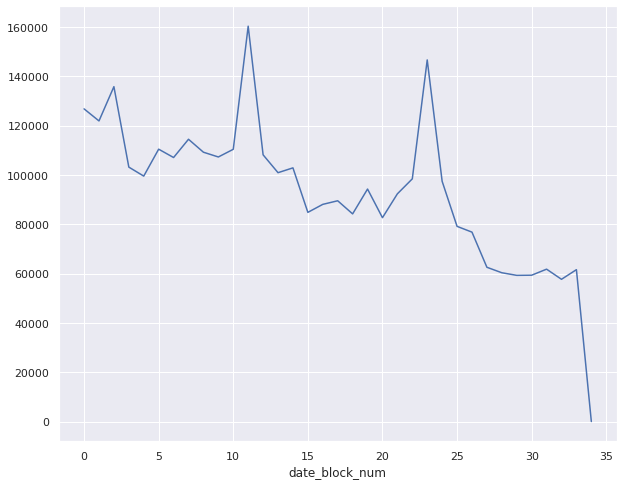

In [ ]:
all_data['target'] = all_data['target'].astype(np.float64) # we cannot calculate sum with float16
sales_per_month = all_data.groupby('date_block_num')['target'].sum()
all_data['target'] = all_data['target'].astype(np.float16)
sales_per_month.plot(figsize=(10,8))

In [ ]:
decembers = [11, 23]
all_data['is_december'] = all_data['date_block_num'].isin(decembers).astype(np.int8)

In [ ]:
all_data = pd.merge(all_data, items_df, how='left', on='item_id')
all_data = pd.merge(all_data, cat_df, how='left', on='item_category_id')
all_data = pd.merge(all_data, shops_df, how='left', on='shop_id')

In [ ]:
all_data['item_category_id'] = all_data['item_category_id'].astype(np.int8)
all_data['type_code'] = all_data['type_code'].astype(np.int8)
all_data['subtype_code'] = all_data['subtype_code'].astype(np.int8)
all_data['city_code'] = all_data['city_code'].astype(np.int16)

In [ ]:
del items_df
del cat_df
del shops_df
gc.collect()

168

In [ ]:
index_cols

['shop_id', 'item_id', 'date_block_num']

In [ ]:
#function to create lag features

def create_lag(df, cols_to_lag, shift_range):
    print(cols_to_lag)
    
    for month_shift in tqdm_notebook(shift_range):
        train_shift = df[index_cols + cols_to_lag].copy()
        train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift

        foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_lag else x
        train_shift = train_shift.rename(columns=foo)

        df = pd.merge(df, train_shift, on=index_cols, how='left')

    del train_shift
    gc.collect()
    return df

In [ ]:
mean_enc = all_data.groupby('date_block_num').agg({'target':['mean']})
mean_enc.columns = ['date_block_num_enc']
all_data = pd.merge(all_data, mean_enc, how='left', on=['date_block_num'])

In [ ]:
all_data = create_lag(all_data, ['date_block_num_enc'], [1, 2, 3, 6, 12])

['date_block_num_enc']


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
ts = time.time()
mean_enc = all_data.groupby(['date_block_num', 'item_id']).agg({'target':['mean']})
mean_enc.columns = ['date_block_num_item_enc']
all_data = pd.merge(all_data, mean_enc, how='left', on=['date_block_num', 'item_id'])

mean_enc = all_data.groupby(['date_block_num', 'shop_id']).agg({'target':['mean']})
mean_enc.columns = ['date_block_num_shop_enc']
all_data = pd.merge(all_data, mean_enc, how='left', on=['date_block_num', 'shop_id'])

mean_enc = all_data.groupby(['date_block_num', 'item_category_id']).agg({'target':['mean']})
mean_enc.columns = ['date_block_num_cat_enc']
all_data = pd.merge(all_data, mean_enc, how='left', on=['date_block_num', 'item_category_id'])

mean_enc = all_data.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'target':['mean']})
mean_enc.columns = ['date_block_num_shop_cat_enc']
all_data = pd.merge(all_data, mean_enc, how='left', on=['date_block_num', 'shop_id','item_category_id'])

mean_enc = all_data.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'target':['mean']})
mean_enc.columns = ['date_block_num_shop_type_enc']
all_data = pd.merge(all_data, mean_enc, how='left', on=['date_block_num', 'shop_id','type_code'])

mean_enc = all_data.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'target':['mean']})
mean_enc.columns = ['date_block_num_shop_subtype_enc']
all_data = pd.merge(all_data, mean_enc, how='left', on=['date_block_num', 'shop_id','subtype_code'])

mean_enc = all_data.groupby(['date_block_num', 'city_code']).agg({'target':['mean']})
mean_enc.columns = ['date_block_num_city_enc']
all_data = pd.merge(all_data, mean_enc, how='left', on=['date_block_num', 'city_code'])

mean_enc = all_data.groupby(['date_block_num', 'item_id','city_code']).agg({'target':['mean']})
mean_enc.columns = ['date_block_num_item_city_enc']
all_data = pd.merge(all_data, mean_enc, how='left', on=['date_block_num', 'item_id','city_code'])

mean_enc = all_data.groupby(['date_block_num', 'type_code']).agg({'target':['mean']})
mean_enc.columns = ['date_block_num_type_enc']
all_data = pd.merge(all_data, mean_enc, how='left', on=['date_block_num', 'type_code'])

mean_enc = all_data.groupby(['date_block_num', 'subtype_code']).agg({'target':['mean']})
mean_enc.columns = ['date_block_num_subtype_enc']
all_data = pd.merge(all_data, mean_enc, how='left', on=['date_block_num', 'subtype_code'])

del mean_enc
gc.collect()
time.time() - ts

34.39818358421326

In [ ]:
lag_features = ['date_block_num_item_enc', 'date_block_num_shop_enc', 'date_block_num_cat_enc',
               'date_block_num_shop_cat_enc', 'date_block_num_shop_type_enc', 'date_block_num_shop_subtype_enc',
               'date_block_num_city_enc', 'date_block_num_item_city_enc', 'date_block_num_type_enc',
               'date_block_num_subtype_enc']
all_data = create_lag(all_data, lag_features, [1, 2, 3, 6, 12])

['date_block_num_item_enc', 'date_block_num_shop_enc', 'date_block_num_cat_enc', 'date_block_num_shop_cat_enc', 'date_block_num_shop_type_enc', 'date_block_num_shop_subtype_enc', 'date_block_num_city_enc', 'date_block_num_item_city_enc', 'date_block_num_type_enc', 'date_block_num_subtype_enc']


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
lag_features

['date_block_num_item_enc',
 'date_block_num_shop_enc',
 'date_block_num_cat_enc',
 'date_block_num_shop_cat_enc',
 'date_block_num_shop_type_enc',
 'date_block_num_shop_subtype_enc',
 'date_block_num_city_enc',
 'date_block_num_item_city_enc',
 'date_block_num_type_enc',
 'date_block_num_subtype_enc']

In [ ]:
all_data.drop(lag_features + ['date_block_num_enc'], inplace=True, axis=1)

In [ ]:
#find out shop mean price for all time and shop mean price for every month
ts = time.time()

group = sales.groupby(['shop_id']).agg({'item_price':['mean']})
group.columns = ['shop_price_mean']

#another way to get rid of 2 layer columns
group.reset_index(inplace=True)
all_data = pd.merge(all_data, group, how='left', on=['shop_id'])
all_data['shop_price_mean'] = all_data['shop_price_mean'].astype(np.float32)

group = sales.groupby(['date_block_num', 'shop_id']).agg({'item_price':['mean']})
group.columns = ['date_shop_price_mean']
group.reset_index(inplace=True)

all_data = pd.merge(all_data, group, how='left', on=['date_block_num', 'shop_id'])
all_data['date_shop_price_mean'] = all_data['date_shop_price_mean'].astype(np.float16)

# create lags 
lags = [1, 2, 3, 4, 5, 6]
all_data = create_lag(all_data, ['date_shop_price_mean'],lags)
time.time() - ts

['date_shop_price_mean']


  0%|          | 0/6 [00:00<?, ?it/s]

133.15253281593323

In [ ]:
# find out how much shop mean month price different from the 'all time' shop mean price , and normalize it.
ts = time.time()

for i in lags:
    all_data['delta_shop_price_lag_'+str(i)] = \
        (all_data['date_shop_price_mean_lag_'+str(i)] - all_data['shop_price_mean']) / all_data['shop_price_mean']


del group
gc.collect()

delta_cols = [col  for col in all_data.columns.values if col.startswith('delta_shop_price_lag_')]
date_item_price_cols = [col  for col in all_data.columns.values if col.startswith('date_shop_price_mean_lag_')]

#fillna(method='backfill') doesn't support float16, so change it to float32
all_data[delta_cols] = all_data[delta_cols].astype(np.float32) 

#get first non nan value in a row.
all_data['delta_shop_price_lag'] = all_data[delta_cols].fillna(method='backfill', axis=1).iloc[:, 0]

#fill it with zeros if it did not found non nan
all_data['delta_shop_price_lag'] = all_data['delta_shop_price_lag'].fillna(0).astype(np.float16)

#and remove feature we used to calculate this
cols_to_drop = delta_cols + date_item_price_cols +['date_shop_price_mean', 'shop_price_mean']
all_data.drop(cols_to_drop, axis=1, inplace=True)
time.time()-ts

3.7540199756622314

In [ ]:
ts = time.time()
group = sales.groupby(['item_id']).agg({'item_price':['mean']})
group.columns = ['item_price_mean']
group.reset_index(inplace=True)
all_data = pd.merge(all_data, group, how='left', on=['item_id'])
all_data['item_price_mean'] = all_data['item_price_mean'].astype(np.float16)

group = sales.groupby(['date_block_num', 'item_id']).agg({'item_price':['mean']})
group.columns = ['date_item_price_mean']
group.reset_index(inplace=True)

all_data = pd.merge(all_data, group, how='left', on=['date_block_num', 'item_id'])
all_data['date_item_price_mean'] = all_data['date_item_price_mean'].astype(np.float16)
lags = [1,2,3,4,5,6]

all_data = create_lag(all_data, ['date_item_price_mean'],lags)

del group
gc.collect()

for i in lags:
    all_data['delta_item_price_lag_'+str(i)] = \
        (all_data['date_item_price_mean_lag_'+str(i)] - all_data['item_price_mean']) / all_data['item_price_mean']

delta_cols = [col  for col in all_data.columns.values if col.startswith('delta_item_price_lag_')]
date_item_price_cols = [col  for col in all_data.columns.values if col.startswith('date_item_price_mean_lag_')]

all_data[delta_cols] = all_data[delta_cols].astype(np.float32) 
all_data['delta_item_price_lag'] = all_data[delta_cols].fillna(method='backfill', axis=1).iloc[:, 0]

all_data['delta_item_price_lag'] = all_data['delta_item_price_lag'].fillna(0).astype(np.float16)
cols_to_drop = delta_cols + date_item_price_cols +['date_item_price_mean', 'item_price_mean']
all_data.drop(cols_to_drop, axis=1, inplace=True)
all_data['delta_item_price_lag'].head()

time.time()-ts

['date_item_price_mean']


  0%|          | 0/6 [00:00<?, ?it/s]

122.86505174636841

In [ ]:
all_data['month'] = all_data['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
all_data['days'] = all_data['month'].map(days).astype(np.int8)

In [ ]:
ts = time.time()
cache = {} # key is 'item_id shop_id', values is date_block_num
all_data['item_shop_last_sale'] = -1
all_data['item_shop_last_sale'] = all_data['item_shop_last_sale'].astype(np.int8)
for idx, row in all_data.iterrows():    
    key = str(row['item_id'])+' '+str(row['shop_id'])
    if key not in cache:
        if row['target']!=0:
            cache[key] = row['date_block_num']
    else:
        last_date_block_num = cache[key]
        all_data.at[idx, 'item_shop_last_sale'] = row['date_block_num'] - last_date_block_num
        cache[key] = row['date_block_num']         

del cache
gc.collect()        
time.time() - ts

644.0226881504059

In [ ]:
ts = time.time()
cache = {}
all_data['item_last_sale'] = -1
all_data['item_last_sale'] = all_data['item_last_sale'].astype(np.int8)
for idx, row in all_data.iterrows():    
    key = row['item_id']
    if key not in cache:
        if row['target']!=0:
            cache[key] = row['date_block_num']
    else:
        last_date_block_num = cache[key]
        if row['date_block_num']>last_date_block_num:
            all_data.at[idx, 'item_last_sale'] = row['date_block_num'] - last_date_block_num
            cache[key] = row['date_block_num']   

            
del cache
gc.collect()
time.time() - ts

442.8790557384491

In [ ]:
ts = time.time()
all_data['item_shop_first_sale'] = all_data['date_block_num'] - all_data.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
all_data['item_first_sale'] = all_data['date_block_num'] - all_data.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

1.5575144290924072

In [ ]:
all_data = all_data[all_data['date_block_num'] > 11]

In [ ]:
all_data.fillna(0, inplace=True, axis=1)

In [ ]:
all_data.to_pickle('all_data.pkl')

In [ ]:
pickle_path = '/content/all_data.pkl'
all_data = pd.read_pickle(pickle_path)
all_data.head()

,shop_id,item_id,date_block_num,target,is_december,item_category_id,type_code,subtype_code,city_code,date_block_num_enc_lag_1,...,date_block_num_type_enc_lag_12,date_block_num_subtype_enc_lag_12,delta_shop_price_lag,delta_item_price_lag,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
4488710,54,10297,12,4.0,0,37,11,1,26,0.411377,...,0.0,0.0,0.132324,0.037933,0,31,1,1,2,2
4488711,54,10296,12,3.0,0,38,11,1,26,0.411377,...,0.0,0.0,0.132324,0.085205,0,31,-1,1,1,1
4488712,54,10298,12,14.0,0,40,11,4,26,0.411377,...,0.0,0.0,0.132324,0.439209,0,31,1,1,3,3
4488713,54,10300,12,3.0,0,37,11,1,26,0.411377,...,0.0,0.0,0.132324,0.160645,0,31,1,1,3,3
4488714,54,10284,12,1.0,0,57,13,7,26,0.411377,...,0.0,0.0,0.132324,-0.073181,0,31,1,1,10,10


In [ ]:
test_items = all_data.loc[all_data['date_block_num']==34,'item_id'].unique()
train_items = all_data.loc[all_data['date_block_num']<34,'item_id'].unique()
items_in_test_and_not_in_train = set(test_items).difference(set(train_items))
print('Items in test and not in train: {0}'.format(len(items_in_test_and_not_in_train)))
items_in_train_and_not_in_test = set(train_items).difference(set(test_items))
print('Items in train and not in test: {0}'.format(len(items_in_train_and_not_in_test)))

test_shops = all_data.loc[all_data['date_block_num']==34,'shop_id'].unique()
print('Number of unique shops: {0}'.format(len(test_shops)))

Items in test and not in train: 378
Items in train and not in test: 12332
Number of unique shops: 42


In [ ]:
missing_shop_item_count = 378 * 42 # all missing item per shop ===> 15876
index_cols = ['shop_id', 'item_id', 'date_block_num']

grid = []
for block_num in all_data.loc[all_data['date_block_num']<34, 'date_block_num'].unique():
    print(block_num)
    
    zero_target_df = all_data[(all_data['date_block_num'] == block_num) & (all_data['target']==0) & 
                              (all_data['item_id'].isin(items_in_train_and_not_in_test))]
    
    idx_to_delete = zero_target_df.sample(missing_shop_item_count, random_state=block_num).index
    all_data.drop(idx_to_delete, inplace=True)
    temp = np.array(list(product(*[test_shops, items_in_test_and_not_in_train, [block_num]])),dtype='int32')
    grid.append(temp)
    
    del zero_target_df
    del idx_to_delete
    del temp
    gc.collect()

#     I think grid is all items that a specific shop(in train data) didn't have in each month
# یعنی اجناسی که هر مغازه در ماه های قبل ۳۴ نفروخته (یا همون نداشته که بفروشه )
#  non of grid rows are in all_data
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


In [ ]:
grid['shop_id'] = grid['shop_id'].astype(np.int16)
grid['item_id'] = grid['item_id'].astype(np.int32)
grid['date_block_num'] = grid['date_block_num'].astype(np.int8)

In [ ]:
all_data = pd.concat([all_data, grid], ignore_index=True, sort=False, keys=index_cols)
all_data[['item_shop_last_sale', 'item_last_sale']].fillna(-1, inplace=True) #-1 is default value in this columns
all_data.fillna(0, inplace=True)

del grid
del test_items
del test_shops
del train_items
del items_in_test_and_not_in_train
del items_in_train_and_not_in_test
gc.collect()

44

In [ ]:
all_data['is_december'] = all_data['is_december'].astype(np.int8)
all_data['item_category_id'] = all_data['item_category_id'].astype(np.int8)
all_data['type_code'] = all_data['type_code'].astype(np.int8)
all_data['subtype_code'] = all_data['subtype_code'].astype(np.int8)
all_data['city_code'] = all_data['city_code'].astype(np.int16)

all_data['month'] = all_data['month'].astype(np.int8)
all_data['days'] = all_data['days'].astype(np.int8)
all_data['item_shop_last_sale'] = all_data['item_shop_last_sale'].astype(np.int8)
all_data['item_last_sale'] = all_data['item_last_sale'].astype(np.int8)
all_data['item_shop_first_sale'] = all_data['item_shop_first_sale'].astype(np.int8)
all_data['item_first_sale'] = all_data['item_first_sale'].astype(np.int8)

In [ ]:
# we added some rows to balance ditribution of our dataset so we need put those new rows in right position
# put added rows in right position
all_test_data = all_data[all_data['date_block_num'] == 34]
all_data = all_data[all_data['date_block_num'] < 34]
all_data.sort_values(['date_block_num'], inplace=True)
all_data = pd.concat([all_data, all_test_data], ignore_index=True, sort=False, keys=index_cols)

del all_test_data
gc.collect()

22

In [ ]:
#if data needs to be fed to CNN

dates = all_data['date_block_num']

last_block = dates.max()
print('Test `date_block_num` is {0}'.format(last_block))

X_train = all_data.loc[dates <  last_block]
Y_train = all_data.loc[dates <  last_block, 'target'].values

X_test =  all_data.loc[dates == last_block]
Y_test =  all_data.loc[dates == last_block, 'target'].values

X_valid = all_data.loc[dates ==  last_block-1]
Y_valid =  all_data.loc[dates == last_block-1, 'target'].values

all_data.to_pickle('all_data.pkl') # will use it later. Now free RAM

del dates
del all_data
gc.collect()

Test `date_block_num` is 34


0

In [ ]:
#if data needs to be fed to lgb

dates = all_data['date_block_num']

last_block = dates.max()
print('Test `date_block_num` is {0}'.format(last_block))

X_train = all_data.loc[dates <  last_block]
X_test =  all_data.loc[dates == last_block]

y_train = all_data.loc[dates <  last_block, 'target'].values
y_test =  all_data.loc[dates == last_block, 'target'].values

X_valid_train = all_data.loc[dates <  last_block-1]
X_valid_test =  all_data.loc[dates == last_block-1]

y_valid_train = all_data.loc[dates <  last_block-1, 'target'].values
y_valid_test =  all_data.loc[dates == last_block-1, 'target'].values

all_data.to_pickle('all_data.pkl') # will use it later. Now free RAM

del dates
del all_data
gc.collect()

In [ ]:
# delete some rows from test
columns_to_delete = ['date_block_num', 'target']
X_valid_train = X_valid_train.drop(columns_to_delete, axis=1)
X_valid_test = X_valid_test.drop(columns_to_delete, axis=1)

X_train = X_train.drop(columns_to_delete, axis=1)
X_test = X_test.drop(columns_to_delete, axis=1)

In [ ]:
#  we need list of column_names in lgb.Dataset()
predictors = X_valid_train.columns.tolist()

In [ ]:
from sklearn.model_selection import StratifiedKFold
bayesian_tr_index, bayesian_val_index = list(StratifiedKFold(2, random_state=12, shuffle=True).split(X_valid_train, y_valid_train))[0]

In [ ]:
predictors = X_valid_train.columns.tolist()

In [ ]:
import lightgbm as lgb

# in bayesian optimization we need to have a black box. this black box is our algorithm which we want to optimize
def lgb_black_box(
    num_leaves,  # int
    min_data_in_leaf,  # int
    learning_rate,
    min_sum_hessian_in_leaf,    # int  
    feature_fraction,
    lambda_l1,
    lambda_l2,
    min_gain_to_split,
    max_depth):
    
    # lgb need some inputs as int but BayesianOptimization library send continuous values values. so we change type.

    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)
    
    # all this hyperparameter values are just for test. our goal in this kernel is how to use bayesian optimization
    # you can see lgb documentation for more info about hyperparameters
    params = {
        'num_leaves': num_leaves,
        'max_bin': 63,
        'min_data_in_leaf': min_data_in_leaf,
        'learning_rate': learning_rate,
        'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
        'bagging_fraction': 1.0,
        'bagging_freq': 5,
        'feature_fraction': feature_fraction,
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'min_gain_to_split': min_gain_to_split,
        'max_depth': max_depth,
        'save_binary': True, 
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'rmse',
        'is_unbalance': True,
        'boost_from_average': False, 
    }
    
    train_data = lgb.Dataset(X_valid_train.iloc[bayesian_tr_index].values,
                            label = y_valid_train[bayesian_tr_index],
                            feature_name=predictors,
                            free_raw_data = False)
    
    
    validation_data = lgb.Dataset(X_valid_train.iloc[bayesian_val_index].values,
                                 label= y_valid_train[bayesian_val_index],
                                 feature_name=predictors,
                                 free_raw_data=False)
    
    num_round = 5000
    clf = lgb.train(params, train_data, num_round, valid_sets = [validation_data], verbose_eval=250,
                 early_stopping_rounds = 50)
    
    predictions = clf.predict(X_valid_train.iloc[bayesian_val_index].values,
                              num_iteration = clf.best_iteration)
    
#      we need to compute a regression score. roc_auc_score is a classification score. we can't use it
#     score = metrics.roc_auc_score(y_valid_train[bayesian_val_index], predictions)
    mse = mean_squared_error(y_valid_train[bayesian_val_index], predictions)
    rmse = np.sqrt(mse)
#     our bayesian optimization expect us to give him increasing number to understand this is getting better
    return -rmse

In [ ]:
# these ranges are not best range for this competition, I just use these base ranges
LGB_bound = {
    "num_leaves" : (5, 20),
    "min_data_in_leaf" : (5, 20),
    "learning_rate" : (0.01, 0.3),
    "min_sum_hessian_in_leaf" : (0.00001, 0.01),
    "feature_fraction" : (0.05, 0.5),
    "lambda_l1" : (0, 5.0),
    "lambda_l2" : (0, 5.0),
    'min_gain_to_split': (0, 1.0),
    'max_depth':(3,15)
}

In [ ]:
!pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from bayes_opt import BayesianOptimization

#  we have 3 parameters for this object. first is function. second is ranges. third is random_state (no matter)
optimizer = BayesianOptimization(
    f=lgb_black_box,
    pbounds = LGB_bound,
    random_state = 13
)
print(optimizer.space.keys)

['feature_fraction', 'lambda_l1', 'lambda_l2', 'learning_rate', 'max_depth', 'min_data_in_leaf', 'min_gain_to_split', 'min_sum_hessian_in_leaf', 'num_leaves']


In [ ]:
init_points = 3
n_iter = 3

optimizer.maximize(init_points = init_points, n_iter = n_iter)

|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | min_ga... | min_su... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 50 rounds.
[250]	valid_0's rmse: 0.805523
[500]	valid_0's rmse: 0.791174
[750]	valid_0's rmse: 0.783847
[1000]	valid_0's rmse: 0.776274
[1250]	valid_0's rmse: 0.773431
Early stopping, best iteration is:
[1445]	valid_0's rmse: 0.771682
|  1        | -0.7717   |  0.4      |  1.188    |  4.121    |  0.2901   |  14.67    |  11.8     |  0.609    |  0.007758 |  14.62    |
Training until validation scores don't improve for 50 rounds.
[250]	valid_0's rmse: 0.879588
[500]	valid_0's rmse: 0.856661
[750]	valid_0's rmse: 0.845217
[1000]	valid_0's rmse: 0.836407
[1250]	valid_0's rmse: 0.829865
[1500]	valid_0's rmse: 0.825084
[1750]	valid_0's rmse: 0.821022
[2000]	valid_0's rmse: 0.8177

In [ ]:
optimizer.max['params']

{'feature_fraction': 0.5,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'learning_rate': 0.3,
 'max_depth': 15.0,
 'min_data_in_leaf': 5.0,
 'min_gain_to_split': 0.0,
 'min_sum_hessian_in_leaf': 0.01,
 'num_leaves': 20.0}

In [ ]:
#use computed params here

optimizer.probe(
    params = optimizer.max['params'],
    lazy = False
)
# if lazy= True  it will run next time I say .maximize
# if lazy = False it will run the optimizing right now.

|  8        | -0.7539   |  0.5      |  0.0      |  0.0      |  0.3      |  15.0     |  5.0      |  0.0      |  0.01     |  20.0     |


In [ ]:
optimized_lgb_params = {
        'num_leaves': int(optimizer.max["params"]["num_leaves"]),
        'max_bin': 63,
        'min_data_in_leaf': int(optimizer.max["params"]["min_data_in_leaf"]),
        'learning_rate': optimizer.max["params"]["learning_rate"],
        'min_sum_hessian_in_leaf': optimizer.max["params"]["min_sum_hessian_in_leaf"],
        'bagging_fraction': 1.0,
        'bagging_freq': 5,
        'feature_fraction': optimizer.max["params"]["feature_fraction"],
        'lambda_l1': optimizer.max["params"]["lambda_l1"],
        'lambda_l2': optimizer.max["params"]["lambda_l2"],
        'min_gain_to_split': optimizer.max["params"]["min_gain_to_split"],
        'max_depth': int(optimizer.max["params"]["max_depth"]),
        'save_binary': True, 
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'rmse',
        'is_unbalance': True,
        'boost_from_average': False, 
    }

In [ ]:
nfold = 5
skf2 = StratifiedKFold(n_splits = nfold, shuffle = True, random_state=68)

In [ ]:
predictions1 = np.zeros((len(y_test), nfold))
i = 1
for train_index, val_index in skf2.split(X_train, y_train):
    train_set_lgb = lgb.Dataset(X_train.iloc[train_index][predictors].values,
                                label= y_train[train_index],
                                feature_name= predictors,
                                free_raw_data=False)
    
    val_set_lgb = lgb.Dataset(X_train.iloc[val_index][predictors].values,
                                label= y_train[val_index],
                                feature_name= predictors,
                                free_raw_data=False)
    clf = lgb.train(optimized_lgb_params, train_set_lgb, 5000, valid_sets = [val_set_lgb],
                   verbose_eval=250, early_stopping_rounds = 50)
    
    predictions1[:,i-1] += clf.predict(X_test[predictors], num_iteration=clf.best_iteration)
    i = i + 1

Training until validation scores don't improve for 50 rounds.
[250]	valid_0's rmse: 0.785962
[500]	valid_0's rmse: 0.768346
[750]	valid_0's rmse: 0.757516
[1000]	valid_0's rmse: 0.752317
[1250]	valid_0's rmse: 0.746774
[1500]	valid_0's rmse: 0.744029
[1750]	valid_0's rmse: 0.739561
[2000]	valid_0's rmse: 0.738529
Early stopping, best iteration is:
[2118]	valid_0's rmse: 0.738236
Training until validation scores don't improve for 50 rounds.
[250]	valid_0's rmse: 0.792313
[500]	valid_0's rmse: 0.774978
[750]	valid_0's rmse: 0.765654
[1000]	valid_0's rmse: 0.756511
[1250]	valid_0's rmse: 0.753053
[1500]	valid_0's rmse: 0.75031
[1750]	valid_0's rmse: 0.745262
[2000]	valid_0's rmse: 0.741419
[2250]	valid_0's rmse: 0.738416
[2500]	valid_0's rmse: 0.737062
[2750]	valid_0's rmse: 0.734656
Early stopping, best iteration is:
[2854]	valid_0's rmse: 0.733406
Training until validation scores don't improve for 50 rounds.
[250]	valid_0's rmse: 0.793467
[500]	valid_0's rmse: 0.777715
[750]	valid_0's r

In [ ]:
su=[sum(i) for i in predictions1]
newList = [ x / 5 for x in su]
newList

In [ ]:
clippedList = [20 if x > 20 else x  for x in newList ]


In [ ]:
submit3 = pd.DataFrame({'ID':range(214200), 'item_cnt_month': clippedList})
submit3.to_csv('submission.csv', index=False)

In [ ]:
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f submission.csv -m "CNN + LSTM with feature engineering"

100% 5.41M/5.41M [00:04<00:00, 1.30MB/s]
Successfully submitted to Predict Future Sales

###Skfold 2

In [ ]:
train_index2, val_index2 = list(StratifiedKFold(2, random_state=12, shuffle=True).split(X_train, y_train))[0]

In [ ]:
# prediction with 1 time of prediction.
predictions = np.zeros((len(y_test), nfold))


train_set_lgb = lgb.Dataset(X_train.iloc[train_index2][predictors].values,
                            label= y_train[train_index2],
                            feature_name= predictors,
                            free_raw_data=False)
    
val_set_lgb = lgb.Dataset(X_train.iloc[val_index2][predictors].values,
                            label= y_train[val_index2],
                            feature_name= predictors,
                            free_raw_data=False)
clf = lgb.train(optimized_lgb_params, train_set_lgb, 5000, valid_sets = [val_set_lgb],
                verbose_eval=250, early_stopping_rounds = 50)
    
predictions = clf.predict(X_test[predictors], num_iteration=clf.best_iteration)

Training until validation scores don't improve for 50 rounds.
[250]	valid_0's rmse: 0.792576
[500]	valid_0's rmse: 0.780005
[750]	valid_0's rmse: 0.771635
[1000]	valid_0's rmse: 0.764724
[1250]	valid_0's rmse: 0.761029
[1500]	valid_0's rmse: 0.759112
[1750]	valid_0's rmse: 0.75665
[2000]	valid_0's rmse: 0.754589
[2250]	valid_0's rmse: 0.750836
[2500]	valid_0's rmse: 0.748853
[2750]	valid_0's rmse: 0.747515
Early stopping, best iteration is:
[2904]	valid_0's rmse: 0.746407


In [ ]:
final = predictions.clip(0,20)

In [ ]:
submit = pd.DataFrame({'ID':range(len(predictions)), 'item_cnt_month': final})
submit.to_csv('submission.csv', index=False)

In [ ]:
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f submission.csv -m "CNN + LSTM with feature engineering"

100% 4.99M/4.99M [00:03<00:00, 1.39MB/s]
Successfully submitted to Predict Future Sales